# KPI analysis for a mobile application

The product owner who is charge of running the development team for a mobile application is interested in better understanding user behaviour. He would also like to check if the high-level KPIs for the application are improving with each release of a new version. Therefore an anlysis was carried out to compare the difference in statistics between older version and a current one.

### Load and parse the data

This analysis will be carried out using Pandas in Python. Matplotlib style visualisations were used to generate graphical summaries. It is understood that some queries on slicing of data would be performed quicker and easier in SQL, but I am more used to manipulating data in Pandas hence the decision.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading and initial inspection of the users data

In [2]:
user = pd.read_csv('users.csv')
user.head(2)

,user_id,install_date,app_version
0,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1
1,0020cb805d63f036ad2c22dd8e76e368,2016-01-16,Unknown


In [3]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
user_id         3900 non-null object
install_date    3900 non-null object
app_version     3900 non-null object
dtypes: object(3)
memory usage: 91.5+ KB


In [7]:
# Check for duplicates in users ID
len(user.user_id.unique())

3900

In [8]:
# Find out earliest install date. This implies dates in the event data should not preceed this date.
# However it should be noted that the dates in the events data does not necessary preceed the latest install date
user['install_date'] = pd.to_datetime(user['install_date'])
print 'Earliest install: ', user['install_date'].min()
print 'Latest install: ', user['install_date'].max()

Earliest install:  2014-12-01 00:00:00
Latest install:  2016-07-31 00:00:00


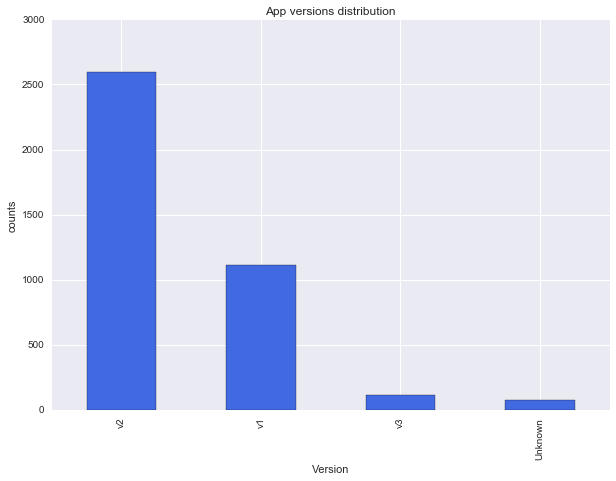

In [10]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
user['app_version'].value_counts().plot(kind='bar', ax=ax, color='royalblue')
ax.set(title='App versions distribution', xlabel='Version', ylabel='counts')
plt.show()

# It can be seen that there are unknown versions in the data. It is possible to estimate app versions for those 
# unknown instances using install date.

In [11]:
pd.pivot_table(user, index=['app_version'], values=['install_date'], aggfunc=[np.min, np.max])

# It seems that v1 of the app is not discontinued after the release of newer versions. Instead it runs in parallel
# (for the purpose of A/B test?). However we can still make reasonable guess by the following rules:
# - If install date is earlier than 2015-05-05, it would be a v1
# - If install date is earlier than 2016-04-17, it would be either a v1 or v2
# - Else it could be either of the 3 versions 

,amin,amax
,install_date,install_date
app_version,,
Unknown,2014-12-06,2016-07-31
v1,2014-12-01,2016-07-29
v2,2015-05-05,2016-07-31
v3,2016-04-17,2016-07-31


In [15]:
# Period 1
user[user['install_date']<'2015-05-05']['app_version'].value_counts()

v1         1003
Unknown      10
Name: app_version, dtype: int64

In [13]:
# Period 2
user[(user['install_date']>='2015-05-05')&(user['install_date']<'2016-04-17')]['app_version'].value_counts()

v2         2373
v1          101
Unknown      60
Name: app_version, dtype: int64

In [14]:
# Period 3
user[user['install_date']>='2016-04-17']['app_version'].value_counts()

v2         223
v3         113
v1          12
Unknown      5
Name: app_version, dtype: int64

From the above enquires it can be seen that there is a total of 75 unknowns. It can be safely assumend that the ones in Period 1 uses v1 of the app. According to the ratio in period 2, there should be 2-3 v1 users. However it would be nearly pointless to estimate the unknown this way. In order to solve this problem we can either assume them to be all v2 users or we can try to do a better estimation when the 2 data sets are combined. There are 5 unknows in period 3 and we face the same problem as we did for period 2. 

For preliminary analysis, it would be acceptable to drop the unknown cases. This is because we have quite a large group of v1 and v2 users (where the majority of the unknown belongs). v3 users number can be a concern but estimating the unknowns would not help in this scenario.

### Loading and initial inspection of the events data

In [4]:
event = pd.read_csv('events.csv')
event.head(2)

,user_id,user_session_id,event_timestamp,app,time_seconds
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,67
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,277


In [5]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27726 entries, 0 to 27725
Data columns (total 5 columns):
user_id            27726 non-null object
user_session_id    27726 non-null object
event_timestamp    27726 non-null object
app                27726 non-null object
time_seconds       27726 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [20]:
len(event.user_id.unique())
# This number does not match up with the user data set. Therefore it can be assumed that there are cases where
# customers downloaded the app but have not actually used it.

2243

In [21]:
len(event.user_session_id.unique())

14098

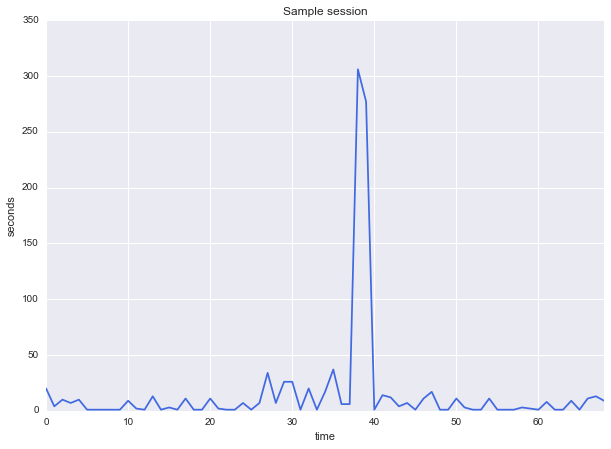

In [34]:
sample_case = event[event.user_session_id=='c636a6a0b454bd211a7930f5baf78f0c'].sort_values('event_timestamp').reset_index()
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
sample_case['time_seconds'].plot( ax=ax, color='royalblue')
ax.set(title='Sample session', xlabel='time', ylabel='seconds')
plt.show()

# There could be multiple events in a unique session. As long as users stay in the app it is considered a single
# session. However the user can visit different parts of the app and when they leave that part an event would be 
# triggered. The following plot demonstrate a series of events in a single session. It can be seen that some of 
# the session durations are very short. It doesn't look like a normal usage. It is more like a bug or users forgetting 
# to lock their screen.

In [35]:
event['event_timestamp'] = pd.to_datetime(event['event_timestamp'])
print 'First recorded event', event['event_timestamp'].min()
print 'Last recorded event', event['event_timestamp'].max()


First recorded event 2015-03-07 00:39:33
Last recorded event 2016-10-05 16:57:16


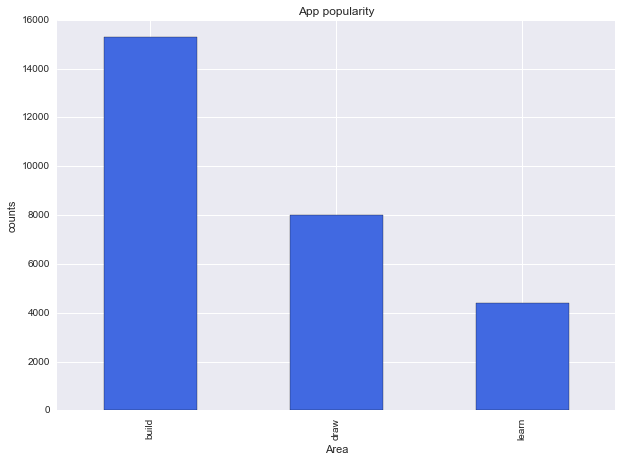

In [37]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
event.app.value_counts().plot(kind='bar', ax=ax, color='royalblue')
ax.set(title='App popularity', xlabel='Area', ylabel='counts')
plt.show()

# It seems that 'build' is the most popular area of the app. However we should take into account the phenomenon 
# discovered in the previous part. Simply counting the number of events might not tell the true story when bugs 
# or unintended operations exist.


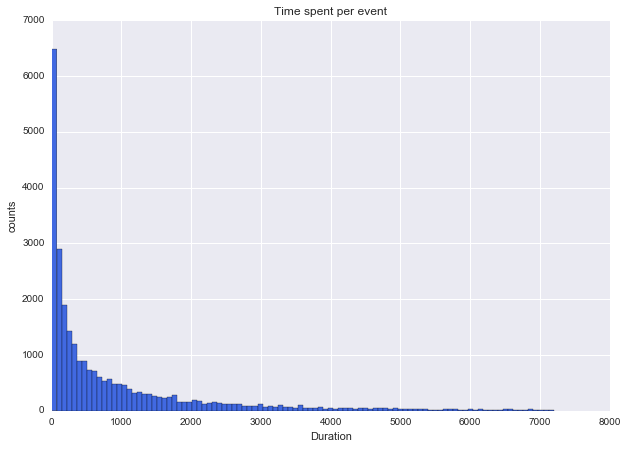

count    27726.000000
mean       918.720876
std       1305.802925
min          1.000000
25%         81.000000
50%        359.000000
75%       1185.750000
max       7195.000000
Name: time_seconds, dtype: float64


In [42]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
event['time_seconds'].hist(bins=100,ax=ax,color='royalblue')
ax.set(title='Time spent per event', xlabel='Duration', ylabel='counts')
plt.show()

print event['time_seconds'].describe()

# It can be seen that time spent in each event can be as short as 1 second. These short sessions do not seem like
# normal usage. Max time spent is 7195 seconds which equals to about 120 minutes. I would say it is a reasonble time
# to spend in an app if you are really engaged. Therefore to conclude, the time data is reasonable and can be trusted.
# However that doesn't necessarily mean they reflect normal user operations. 

### KPIs
- Total Users
- Monthly Active Users
- Retention
- Time in app
- Users page visit analysis


### Total Users

Total user number is cumulative measure across a period of time. Therefore it is expected to always see an upward sloping line no matter what the gradient is. This metric is useful to see how well the app/company is doing in terms of gathering new users and how the user base changes in size. This in turns affect the firm's marketing strategy and other important decisions such as server capacities.

In [43]:
user = user[user['app_version']!='Unknown']
app_ver = pd.get_dummies(user['app_version'])
user = pd.concat([user,app_ver],axis=1)
user.head(2)

,user_id,install_date,app_version,v1,v2,v3
0,000a0efdaf94f2a5a09ab0d03f92f5bf,2014-12-25,v1,1,0,0
2,002a9119a4b3dfb05e0159eee40576b6,2015-12-29,v2,0,1,0


In [54]:
total_users = pd.pivot_table(user, index=['install_date'], values=['v1','v2','v3'], aggfunc=np.sum)


In [55]:
total_users = np.cumsum(total_users)

In [56]:
total_users.reset_index(inplace=True)

In [61]:
total_users['total'] = total_users['v1']+total_users['v2']+total_users['v3']

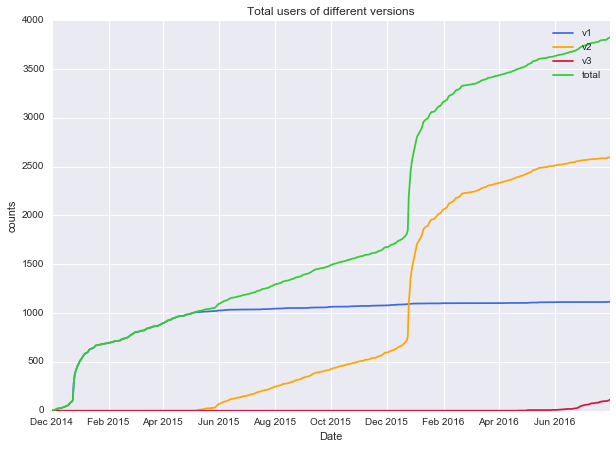

In [65]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot('install_date','v1',data=total_users, color='royalblue')
ax.plot('install_date','v2',data=total_users, color='orange')
ax.plot('install_date','v3',data=total_users, color='crimson')
ax.plot('install_date','total',data=total_users, color='limegreen')
ax.set(title='Total users of different versions', xlabel='Date', ylabel='counts')
plt.legend()
plt.show()

# From the plot it can be seen that the app had 2 rapid growing phases (late Dec 2014 and late Dec 2015).
# The growth in between is very steady. We can see that v2 of the app was launched in May 2015 and takes over from v1.
# However there is no significant change in the app installation rate. There is another large increase in installation 
# between late Dec 2015 and Jan 2016. It could be interesting and worthwhile to further investigate the cause of the
# change.

### Monthly Active Users

This metric measures the number of unique users that have used the app within a month. This is an important metric as it tells us how popular the app is.

In [69]:
event['year'] = event['event_timestamp'].apply(lambda x:x.year)
event['month'] = event['event_timestamp'].apply(lambda x:x.month)

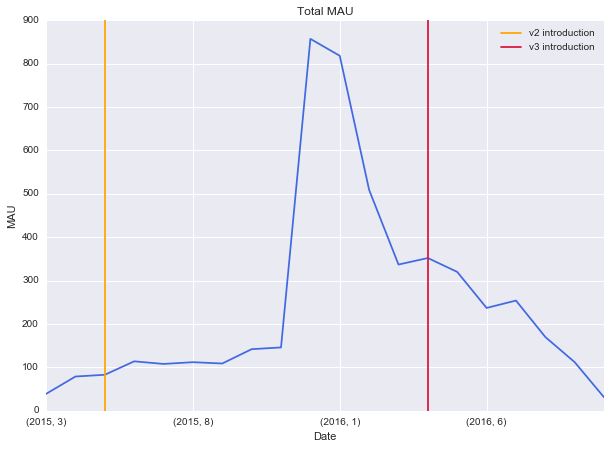

In [109]:
# Note that 2015 March and 2016 Oct are not complete months
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
event.groupby(['year','month']).user_id.nunique().plot(color='royalblue',label='')
ax.set(title='Total MAU', xlabel='Date', ylabel='MAU')
ax.axvline(2, color='orange', label='v2 introduction')
ax.axvline(13, color='crimson', label = 'v3 introduction')
plt.legend()
plt.show()


In [86]:
# Merging the datasets allow us to look at MAU for individual versions of the app.
# user is merged into event using a left join. This is because we are mainly interested in the number of unique users 
# that have used the app but not all users.
merged_df = event.merge(user, on='user_id', how='left')

In [87]:
# What the merged_df looks like
merged_df.head()

,user_id,user_session_id,event_timestamp,app,time_seconds,year,month,install_date,app_version,v1,v2,v3
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,67,2015,3,2015-03-21,v1,1,0,0
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,277,2015,3,2015-01-26,v1,1,0,0
2,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 21:15:33,build,779,2015,3,2015-01-26,v1,1,0,0
3,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 02:17:00,build,145,2015,3,2015-03-22,v1,1,0,0
4,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 03:26:03,draw,319,2015,3,2015-03-22,v1,1,0,0


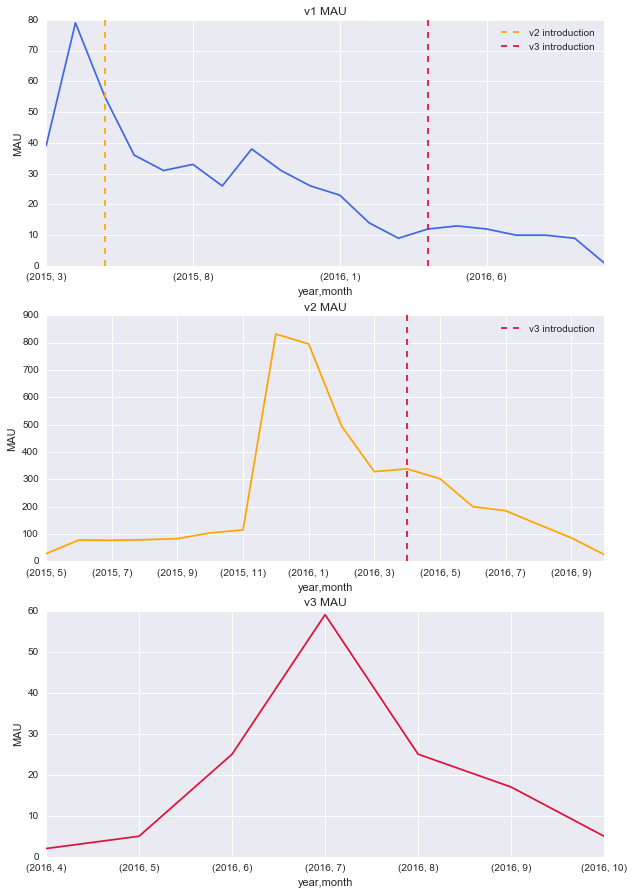

In [108]:
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
merged_df[merged_df['app_version']=='v1'].groupby(['year','month']).user_id.nunique().plot(ax=ax1,color='royalblue',label='')
merged_df[merged_df['app_version']=='v2'].groupby(['year','month']).user_id.nunique().plot(ax=ax2,color='orange',label='')
merged_df[merged_df['app_version']=='v3'].groupby(['year','month']).user_id.nunique().plot(ax=ax3,color='crimson')
ax1.set(ylabel='MAU', title='v1 MAU')
ax1.axvline(2,color='orange',ls='--',label='v2 introduction')
ax1.axvline(13,color='crimson',ls='--',label='v3 introduction')
ax1.legend()
ax2.set(ylabel='MAU', title='v2 MAU')
ax2.axvline(11,color='crimson',ls='--',label='v3 introduction')
ax2.legend()
ax3.set(ylabel='MAU', title='v3 MAU')
plt.show()

The above plots shows the MAU for different versions of the app. It can be seen that the record starts in March 2015 which is well after the first installation date recorded in the user data. Therefore the trend shown in v1 MAU might not tell the whole story. Nevertheless we can see MAU peaks at about 80 for v1 of the app. Shortly after that v2 was introduced and the MAU of v1 is on a steady decline. A decline is expected as it is normal for some users to cease using the app as time goes by. It is also caused by the introduction of v2 so new installation (and use) of v1 would
significantyl slow down.

v2 starts in May 2015 and the MAU gradually increased to over 100 in Nov 2015. Then a huge increase occured in Dec 2015 reaching a new record high of over 800 active users per month. Then MAU started to decline sharply from Jan to Mar 2016. As v3 was introduced in Apr 2016, the MAU continued to drop to a number of under 50 in Oct 2016.

v3 started in Apr 2016 and its MAU rises to a peak of about 60 in Jul 2016. However the number dropped continuously to below 10 in Oct 2016.

There are a few interesting insight from this MAU analysis and they are as follows:
1. There is an exceptional high peak near Dec 2015. It could be due to the fact that the app is related to products that are (can be) sold as Christmas presents (such as Kano's computer kits). Therefore when Chritmas time came, the amount of users rose sharply. This can be further verified by doing a Daily Active Users (DAU) analysis for Dec 2015. If this is proved to be the case, we might want to also look at the data for Dec 2016. If the data shows a similar trend, the company can adjust it's sales/marketing/logistic strategy to better fulfill demand in the coming Christmas.

2. Comparing data between 2015 and 2016, it might be worthwhile to revisit the design/performance of v3. v3 was released in Apr 2016, arguably in a similar period when v2 was released back in 2015. However v3 hadn't demonstrate a similar amount of growth like v2. The growth in MAU stopped within 3 months with a significantly lower peak when compared to v2. Therefore it could be problem of the v3 app, or in a worse case the product is becoming less popular.


In [115]:
merged_df['day'] = merged_df['event_timestamp'].apply(lambda x:x.day)
dec_dau = merged_df[(merged_df['year']==2015)&(merged_df['month']==12)].groupby(['day'])['user_id'].nunique()

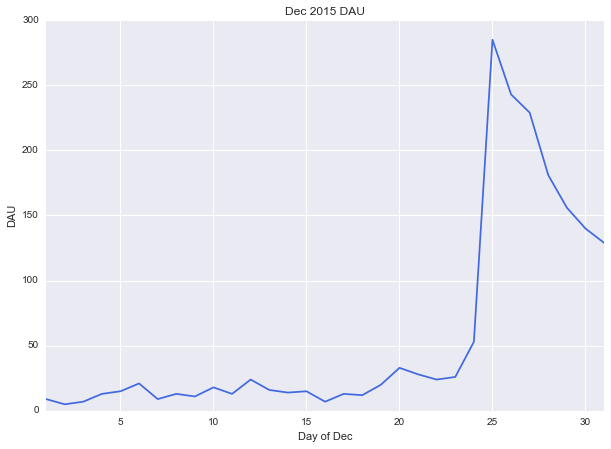

In [118]:
# DAU for Dec 2015
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
dec_dau.plot(color='royalblue',label='')
ax.set(title='Dec 2015 DAU', xlabel='Day of Dec', ylabel='DAU')
plt.show()

# As expected the peaking of active users was caused by Christmas. It can be seen that DAU peaked at 25th Dec and
# drops off quickly towards the end of the month. This is not necessarily a bad thing though. It all depends on the
# company's strategy and how it makes its profit.

### Retention

The definition of retention varies dpending on the company's objective. In this case I would like to use the Rolling Retention as defined in <a href='http://www.applift.com/blog/user-retention'>Applift</a>. The definition of this retention is the proportion of users come back to the app on Day+N or any day after that. As we can see from the DAU graph we kind of get a feeling that not every user would come back everyday. Therefore it would be more appropriate to use a rolling retention to check whether users come back occasionally even after a certain amount of time, which is a hint that they are still interested in the product.

In [128]:
from datetime import timedelta
merged_df.iloc[1]['install_date']+timedelta(days=1)

Timestamp('2015-01-27 00:00:00')

In [150]:
rolling_retention = merged_df.groupby('user_id')['event_timestamp','install_date','app_version'].max().sort_values('install_date')
rolling_retention.head(2)

,event_timestamp,install_date,app_version
user_id,,,
2b4e2d8f4511af84102b477cfb640b6b,2016-07-30 08:21:53,2014-12-05,v1
09c48296367881825f257bd3bef6e944,2016-05-07 08:24:12,2014-12-13,v1


In [190]:
def convert_format(x):
    if x:
        return 1 
    return 0

interval = np.linspace(30,240,8)
rolling_retention['7_days'] = rolling_retention['install_date']+timedelta(days=7)<rolling_retention['event_timestamp']
rolling_retention['7_days'] = rolling_retention['7_days'].apply(convert_format)
for i in interval:
    rolling_retention[str(int(i))+'_days'] = rolling_retention['install_date']+timedelta(days=i)<rolling_retention['event_timestamp']
    rolling_retention[str(int(i))+'_days'] = rolling_retention[str(int(i))+'_days'].apply(convert_format)

In [191]:
rolling_retention.head()

,event_timestamp,install_date,app_version,7_days,30_days,60_days,90_days,120_days,150_days,180_days,210_days,240_days
user_id,,,,,,,,,,,,
2b4e2d8f4511af84102b477cfb640b6b,2016-07-30 08:21:53,2014-12-05,v1,1,1,1,1,1,1,1,1,1
09c48296367881825f257bd3bef6e944,2016-05-07 08:24:12,2014-12-13,v1,1,1,1,1,1,1,1,1,1
e1b622c3797b6eed1ffa457ea337f64c,2015-10-24 12:58:37,2014-12-17,v1,1,1,1,1,1,1,1,1,1
8557065b1f0e775c2541ccee31b59c28,2015-10-28 12:21:26,2014-12-17,v1,1,1,1,1,1,1,1,1,1
0c0562e4fd1ac7997539bb7b5f8f0974,2015-12-19 20:39:11,2014-12-21,v1,1,1,1,1,1,1,1,1,1


In [184]:
rolling_retention.reset_index(drop=True)
rolling_retention_summary = rolling_retention.groupby('app_version')['7_days','30_days','60_days','90_days',
                                                                     '120_days','150_days','180_days','210_days',
                                                                     '240_days'].mean()


In [192]:
days = [7,30,60,90,120,150,180,210,240]
rolling_retention_summary

,7_days,30_days,60_days,90_days,120_days,150_days,180_days,210_days,240_days
app_version,,,,,,,,,
v1,0.811927,0.766055,0.729358,0.688073,0.633028,0.582569,0.509174,0.477064,0.426606
v2,0.616495,0.464433,0.371134,0.310825,0.247938,0.186082,0.139691,0.104124,0.065464
v3,0.505882,0.329412,0.188235,0.058824,0.011765,0.000000,0.000000,0.000000,0.000000


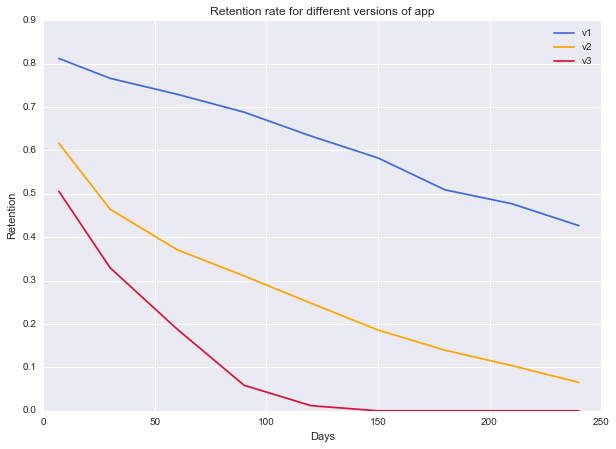

In [189]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot(days,rolling_retention_summary.iloc[0],label='v1',color='royalblue')
ax.plot(days,rolling_retention_summary.iloc[1],label='v2',color='orange')
ax.plot(days,rolling_retention_summary.iloc[2],label='v3',color='crimson')
ax.set(xlabel='Days', ylabel='Retention',title='Retention rate for different versions of app')
plt.legend()
plt.show()

The above plot shows the retention rate for different versions of the app at different days after installation. It can be seen that the retention rate of v1 is the highest with over 50% of the customers continued using the app half a year. v2 seems to be significant worse in terms of rate. However we should bare in mind that a large number users signed up (installed) the app during the Christmas period. It could be that the majority of them were not long term users hence left very soon after installation. This boosted the total number installed hence lowering the overall rate. The declining slope of v2 is actually quite similar to v1 hence further investigation has to be done in order to better compare v1 and v2. v3 however, seems to be underperforming. The slope of the retention curve is steeper and the app only managed to retain about half of its user 7 days since installation. Combining with other metrics such as total users and MAU, it can almost be certain that v3 is not performing particularly well.

### Time spent in app

Time spent in app is a useful metric which is used by analyst to understand the usage pattern of customers. It is very likely that the longer the user stay per session, the more engaged they were. From this data we can only tell the duration of sessions between events. There was no logging about users interaction hence it is not possible to tell what the users were doing when the app was running. Nevertheless this should still be an interesting metric to look at

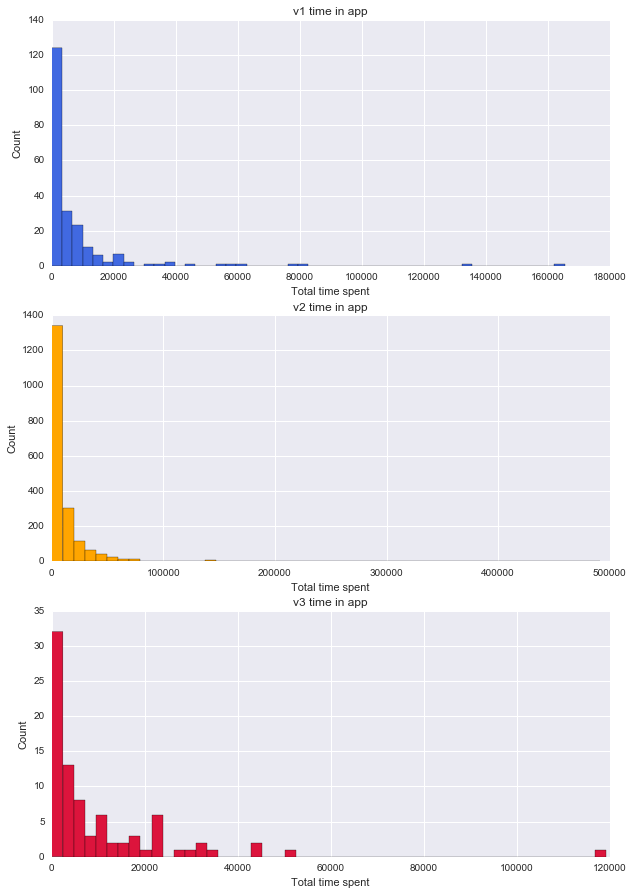

v1 mean:  7915.87614679
v1 median:  2311.5
v1 std:  18157.7038482
v2 mean:  11776.8314433
v2 median:  5201.5
v2 std:  23009.7466204
v3 mean:  10585.1882353
v3 median:  3880.0
v3 std:  16496.20663


In [323]:
v1_time = merged_df[merged_df['app_version']=='v1'].groupby(['user_id']).time_seconds.sum()
v2_time = merged_df[merged_df['app_version']=='v2'].groupby(['user_id']).time_seconds.sum()
v3_time = merged_df[merged_df['app_version']=='v3'].groupby(['user_id']).time_seconds.sum()
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
v1_time.hist(bins=50,ax=ax1,color='royalblue')
v2_time.hist(bins=50,ax=ax2,color='orange')
v3_time.hist(bins=50,ax=ax3,color='crimson')
ax1.set(xlabel='Total time spent', ylabel='Count',title='v1 time in app')
ax2.set(xlabel='Total time spent', ylabel='Count',title='v2 time in app')
ax3.set(xlabel='Total time spent', ylabel='Count',title='v3 time in app')
plt.show()
print 'v1 mean: ', v1_time.mean()
print 'v1 median: ',v1_time.median()
print 'v1 std: ',v1_time.std()
print 'v2 mean: ', v2_time.mean()
print 'v2 median: ', v2_time.median()
print 'v2 std: ', v2_time.std()
print 'v3 mean: ', v3_time.mean()
print 'v3 median: ', v3_time.median()
print 'v3 std: ', v3_time.std()

In [257]:
from __future__ import division
v1 = merged_df[merged_df['app_version']=='v1'].groupby(['user_id']).time_seconds.sum()
v3 = merged_df[merged_df['app_version']=='v3'].groupby(['user_id']).time_seconds.sum()
v2 = merged_df[merged_df['app_version']=='v2'].groupby(['user_id']).time_seconds.sum()
v3_mean = v3.mean()
v2_mean = v2.mean()
v1_mean = v1.mean()
mean_diff12 = abs(v2_mean-v1_mean)
mean_diff23 = abs(v3_mean-v2_mean)
mean_diff13 = abs(v3_mean-v1_mean)
combined12 = np.concatenate((v2.values,v1.values))
combined23 = np.concatenate((v2.values,v3.values))
combined13 = np.concatenate((v1.values,v3.values))
out12 = []
out23 = []
out13 = []
for i in range(50000):
    perm12 = np.random.permutation(combined12)
    perm23 = np.random.permutation(combined23)
    perm13 = np.random.permutation(combined13)
    T12 = abs(perm12[:len(v1)].mean() - perm12[len(v1):].mean())
    T23 = abs(perm23[:len(v2)].mean() - perm23[len(v2):].mean())
    T13 = abs(perm13[:len(v1)].mean() - perm13[len(v1):].mean())
    out12.append(T12>mean_diff12)
    out23.append(T23>mean_diff23)
    out13.append(T13>mean_diff13)
print 'p-value for v1,v2: ',np.mean(out12)
print 'p-value for v2,v3: ',np.mean(out23)
print 'p-value for v1,v3: ',np.mean(out13)

# In order to quantify the difference in total time spent in app, permutation (randomization) tests were conducted. A permutation test is a 
# hypothesis test that gives us an idea of whether the groups of data we have are significantly different. In terms of
# hypothesis tests, t-test are more popular. However it is required that the data used in t-tests is normally 
# distributed. It is obviously not the true in our case. Like the t-test, statistically significance can be determined
# by looking at the p-values. If the p-value is lower than the predetermined alpha level (0.05 is a commonly used 
# figure), the difference would said to be significant.

# From the values obtained, it can be seen that the p-value for the test between v1 and v2 is 0.018. This means that in 
# terms of total time spent in app, v2 is significantly different from v1. However other statistics show values that are
# higher than 0.05 hence cannot be proved to be significant. One thing that has to be noticed is that from the results
# between v2,v3 and v1,v3, it seems that they are all not significantly different. However as mentioned above the result
# between v1,v2 suggested otherwise. This could require more tests to be done to further confirm their relationship.

p-value for v1,v2:  0.01848
p-value for v2,v3:  0.62574
p-value for v1,v3:  0.24484


In [259]:
app = pd.get_dummies(merged_df['app'])
merged_df = pd.concat([merged_df,app],axis=1)
merged_df.head()

,user_id,user_session_id,event_timestamp,app,time_seconds,year,month,install_date,app_version,v1,v2,v3,day,build,draw,learn
0,02fd5305cce536a1940aea0818ba7a3d,6690452e89aa62cdfa818d1f469aaf37,2015-03-22 00:08:12,build,67,2015,3,2015-03-21,v1,1,0,0,22,1,0,0
1,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 20:56:29,build,277,2015,3,2015-01-26,v1,1,0,0,22,1,0,0
2,955ef0ba3e7de00197f2ab6828cb4d05,af2d613e4e5695fd4d8610a0086de760,2015-03-22 21:15:33,build,779,2015,3,2015-01-26,v1,1,0,0,22,1,0,0
3,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 02:17:00,build,145,2015,3,2015-03-22,v1,1,0,0,22,1,0,0
4,3768b95029f051316727e5413362dcff,7af8b316d551662e89ef0afbedd06be8,2015-03-22 03:26:03,draw,319,2015,3,2015-03-22,v1,1,0,0,22,0,1,0


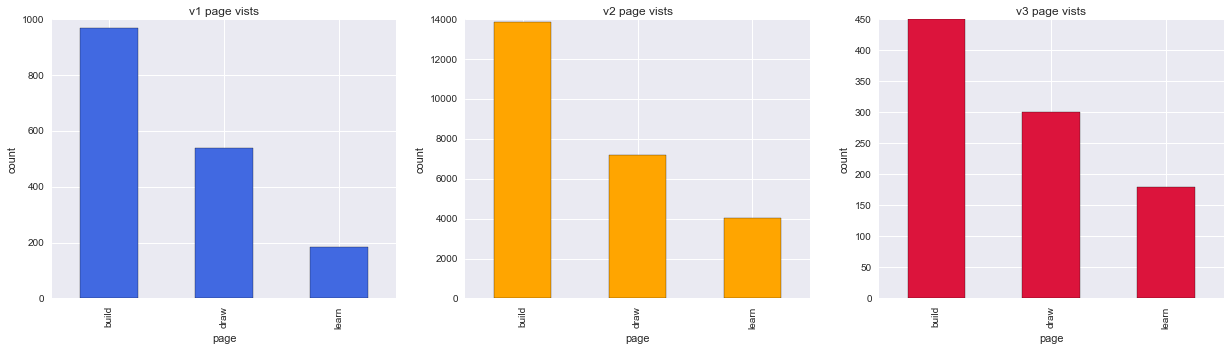

In [281]:
function = merged_df[merged_df['time_seconds']>30].groupby('app_version')['build','draw','learn'].sum()
fig = plt.figure(figsize=(21,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
function.iloc[0].plot(kind='bar',ax=ax1,color='royalblue')
function.iloc[1].plot(kind='bar',ax=ax2,color='orange')
function.iloc[2].plot(kind='bar',ax=ax3,color='crimson')
ax1.set(title='v1 page vists', xlabel='page', ylabel='count')
ax2.set(title='v2 page vists', xlabel='page', ylabel='count')
ax3.set(title='v3 page vists', xlabel='page', ylabel='count')
plt.show()

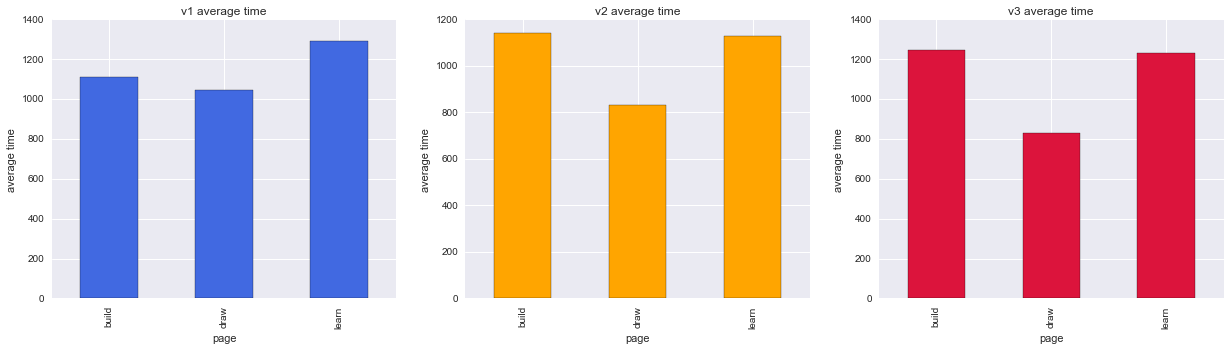

In [282]:
time_per_function = pd.pivot_table(merged_df[merged_df['time_seconds']>30], index=['app_version'],values=['time_seconds'],columns=['app'])
fig = plt.figure(figsize=(21,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
time_per_function.iloc[0].plot(kind='bar',ax=ax1,color='royalblue')
time_per_function.iloc[1].plot(kind='bar',ax=ax2,color='orange')
time_per_function.iloc[2].plot(kind='bar',ax=ax3,color='crimson')
ax1.set(title='v1 average time', xlabel='page', ylabel='average time', xticklabels=['build','draw','learn'])
ax2.set(title='v2 average time', xlabel='page', ylabel='average time', xticklabels=['build','draw','learn'])
ax3.set(title='v3 average time', xlabel='page', ylabel='average time', xticklabels=['build','draw','learn'])
plt.show()

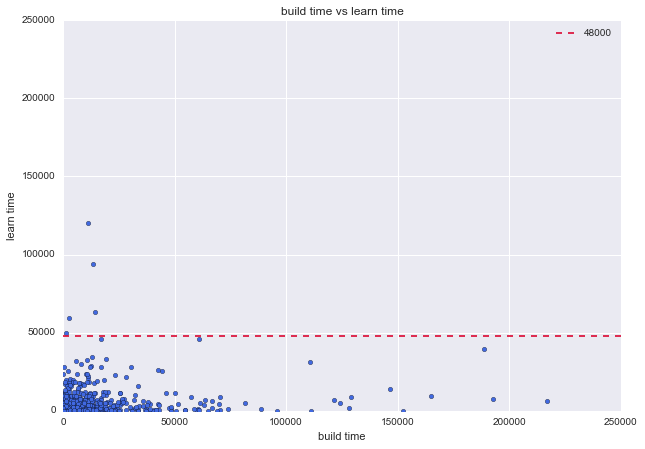

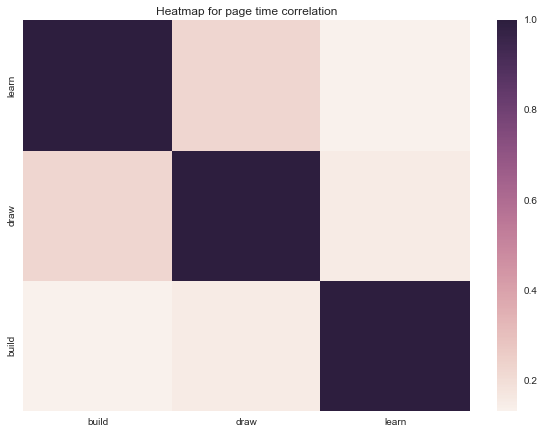

In [325]:
have_learn = merged_df[merged_df['learn']==1]['user_id']
user_learn = merged_df[merged_df['user_id'].isin(have_learn)]
#user_learn.groupby(['user_id','app'])['time_seconds'].sum()
user_learn_page = pd.pivot_table(user_learn, index=['user_id'], values=['time_seconds'], columns=['app'], aggfunc=np.sum)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(user_learn_page['time_seconds']['build'],user_learn_page['time_seconds']['learn'],c='royalblue',label='')
ax.set(xlim=[0,250000], ylim=[0,250000],title='build time vs learn time', xlabel='build time', ylabel='learn time')
ax.axhline(48000,ls='--',c='crimson', label='48000')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
sns.heatmap(user_learn_page.corr(),ax=ax)
ax.set(xticklabels=['build','draw','learn'], yticklabels=['build','draw','learn'], xlabel='', ylabel='', 
       title='Heatmap for page time correlation')
plt.show()

In [322]:
print user_learn_page['time_seconds']['build'].median()
print user_learn_page['time_seconds']['learn'].median()

3833.5
700.0


From the preliminary analysis we saw that some of the sessions only lasted for a few seconds which could represent non-meaningful (purposeful) interactions. Therefore it is decided to set a threshold time and below which the session would be considered not-interested. Without the knowledge of what the individual pages do, the threshold would needed to be set by common sense and rationality. Recalling previous app using experiences, 30 seconds seems to be a reasonable starting point. 

Having filtered out the data, bar charts were produced to measure and compare visit counts and visit time for the different pages in the 3 seperate versions. The above plots show a very interesting finding. It can be seen that although the learning page has the lowest amount of visits across all versions, users tend to stay the longest there. It either mean that the page itself requires a long staying time for users to achieve its purpose (the name 'learn' could imply its some kind of instructions) or it could mean that the users who ened up in this section of the app were really enjoying it.

Since a relatively small amount of users tend to spend a long time in the "learn" page, it is suspected that those are the enthusiatic users. Therefore it would be interesting to see whether those users spend more time on other pages too. Having plotted a heatmap and scatter plot, it seems that the time spent in the pages are not that correlated. The scatter plot showed that for users who had visited both the "learn" and "build" page, only a few of them have spent over 50000 seconds in the "learn" page whilst it is much more common for the "build" page. In fact the difference in median value is over 3000 seconds (50 minutes).  